In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

In [2]:
class SEIRModel():
    """対象のモデル"""
    
    LAMBDA = 166 # per day # 出生人数
    #CONTACT = 0.03 # 感染確率をまとめたもの
    CONTACT_E  = 0.10 # 感染確率SとE #他の論文引用 #Datafitting
    CONTACT_I  = 0.10 # 感染確率SとI #他の論文引用 #Datafitting
    CONTACT_S1  = 0.0168 # ワクチン接種者の感染確率
    THETA1 = 4.45e-3 # per/day # 1回目ワクチン接種率
    THETA2 = 4.88e-3 # per/day # 2回目ワクチン接種率
    #SEVERE = 0.016 # 重症化率
    MU = 2.92e-5 # per day # 自然死亡率
    ALPHA = 1/7 # 潜伏期間の逆数
    RATE_W = 0.01 # per day # ウイルスの致死率
    GAMMA = 1/15 # per day # 回復率
    COFFIENT1 = 3.0e8 # 調整係数 # DataFitting
    COFFIENT2 = 3.0e8 # 調整係数 # DataFitting
    COFFIENT3 = 3.0e8 # 調整係数 # DataFitting
    #COFFIENT4 = #3.0*10**(10) # 調整係数 # DataFitting
    #COFFIENT5 = #3.0*10**(10) # 調整係数 # DataFitting
    SPAN1 = 1/14 # ワクチン1回目の効果期間
    SPAN2 = 1/10 # ワクチン2回目の効果期間 (7と14の平均でもいいし、どっちのワクチンでも)
    SPAN12 = 1/28
    TOTAL = 8800000
    
    S_0 = 3500000
    E_0 = 2368
    I_0 = 1856
    R_0 = 5259708
    S1_0 = 36068

    sol = None

    def __init__(self, **kwargs):
        self.TIME_INTERVAL = kwargs.pop('TIME_INTERVAL')

    
    
    def set_param(self, COFFIENT4, COFFIENT5):
        """パラメータをセット"""
        
        self.COFFIENT4 = COFFIENT4
        self.COFFIENT5 = COFFIENT5
    

    def dSdt(self, S, E, I, S1,):
        """Sの時間微分"""
        return self.LAMBDA - \
            (self.CONTACT_E*S*E/self.TOTAL+ self.CONTACT_I*S*I/self.TOTAL) - \
                S*(self.SPAN1*self.THETA1/(1+self.COFFIENT4*S1)+self.MU)
        
    def dEdt(self,S, E, I, S1,):
        """Eの時間微分"""
        return (self.CONTACT_E*S*E/self.TOTAL + \
            self.CONTACT_I*S*I/self.TOTAL+self.CONTACT_S1*S1*I/self.TOTAL+self.CONTACT_S1*S1*E/self.TOTAL) - \
                E*(self.MU+self.ALPHA)

    def dIdt(self, E, I,):
        """Iの時間微分"""
        return self.ALPHA*E - I*(self.RATE_W + self.MU + self.GAMMA)

    def dRdt(self, R, I, S1,):
        """Rの時間微分"""
        return S1*self.SPAN2*self.THETA2*self.SPAN12/(1+self.COFFIENT5*S1) + self.GAMMA*I - R*self.MU

    def dS1dt(self, S, E, I, S1,):
        """S1の時間微分"""
        return S*self.SPAN1*self.THETA1/(1+S1*self.COFFIENT4) - \
            S1*(self.SPAN2*self.THETA2*self.SPAN12/(1+S1*self.COFFIENT5) + self.MU) - \
                (self.CONTACT_S1*S1*I/self.TOTAL)-(self.CONTACT_S1*S1*E/self.TOTAL)

    def dX(self, t, X):
        """状態ベクトルの微分
        
        状態ベクトルの微分を計算
        """
        S, E, I, R, S1 = X
        # 微分方程式を配列に保存
        return np.array([
            self.dSdt(S, E, I, S1),
            self.dEdt(S, E, I, S1),
            self.dIdt(E, I),
            self.dRdt(R, I, S1),
            self.dS1dt(S, E, I, S1),
        ])


    def run_sim(self, t):
        """微分方程式を数値的に解く"""
        
        X_init = np.array(
            [self.S_0, self.E_0, self.I_0, self.R_0, self.S1_0]
        )
        
        self.sol = solve_ivp(
            fun=self.dX,
            t_span=(0, max(t)),
            y0=X_init,
            t_eval=t,
        )

In [3]:
class Fitting(SEIRModel):
    """フィッティング"""
    
    COFFIENT4s = []
    COFFIENT5s = []
    
    def __init__(self, animated, **kwargs):
        """
        
        Parameters
        ---
        animated : Bool  
            アニメ有り無し
        """
        
        self.animated = animated
        self.t_observed = kwargs.pop('t_observed')
        self.S1_observed = kwargs.pop('S1_observed')
        super().__init__(**kwargs)
    
    
    def draw(self, auto_close=False):
        """図を書く"""
        
        fig = plt.figure(figsize=(20, 5))
        ax = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        
        ax.scatter(self.t_observed, self.S1_observed, label="real S1")
        ax.set_xlim(0,76)
        
        if self.sol is None:
            pass
        else:
            #ax.plot(self.sol.t, self.sol.y[0], label="fitting S")
            #ax.plot(self.sol.t, self.sol.y[1], label="fitting E")
            #ax.plot(self.sol.t, self.sol.y[2], label="fitting I")
            #ax.plot(self.sol.t, self.sol.y[3], label="fitting R")
            ax.plot(self.sol.t, self.sol.y[4], label="fitting S1")
            ax2.plot(self.COFFIENT4s, label="COFFIENT4")
            ax3.plot(self.COFFIENT5s, label="COFFIENT5")
        
        ax.legend()
        ax.grid()
        ax.set_xlabel("day")
        ax.set_ylabel("vaccine")
        
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel("trial")

        ax3.legend()
        ax3.grid()
        ax3.set_xlabel("trial")
        
        plt.show(block=auto_close)
        plt.pause(0.8)
        plt.close('all')


    def S1(self, t, COFFIENT4, COFFIENT5):
        """S1を計算
        
        Parameters
        ---
        t : 
        
        """
        
        self.COFFIENT4s.append(COFFIENT4)
        self.COFFIENT5s.append(COFFIENT5)
        
        
        print("(COFFIENT4, COFFIENT5) = ", COFFIENT4, " , ", COFFIENT5)
        self.set_param(COFFIENT4, COFFIENT5)
        
        self.run_sim(t)
        
        if self.animated:
            self.draw()
        
        return self.sol.y[4]


    def find_param(self, p_init,):
        """最適化
        
        Parameters
        ---
        p_init : パラメータの初期値
        """
        
        popt, pcov = curve_fit(
            f = self.S1,
            xdata = self.t_observed,
            ydata = self.S1_observed,
            p0 = p_init
        )
        
        return popt, pcov 

(COFFIENT4, COFFIENT5) =  0.000101  ,  0.000101


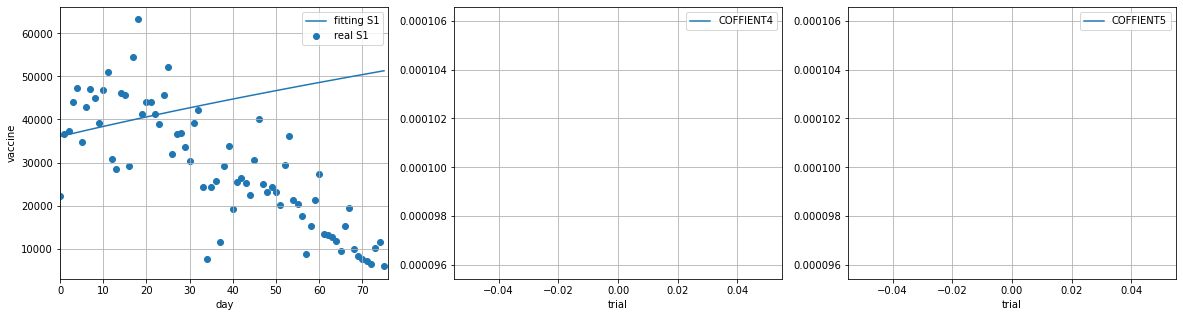

(COFFIENT4, COFFIENT5) =  0.000101  ,  0.000101


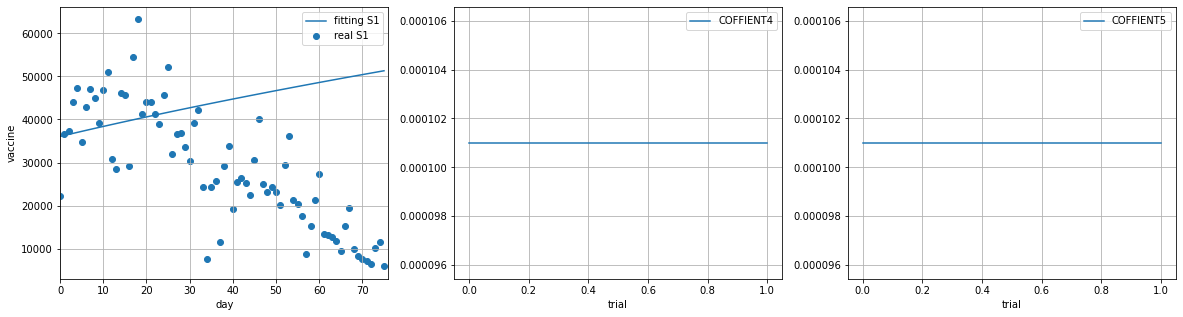

(COFFIENT4, COFFIENT5) =  0.000101  ,  0.000101


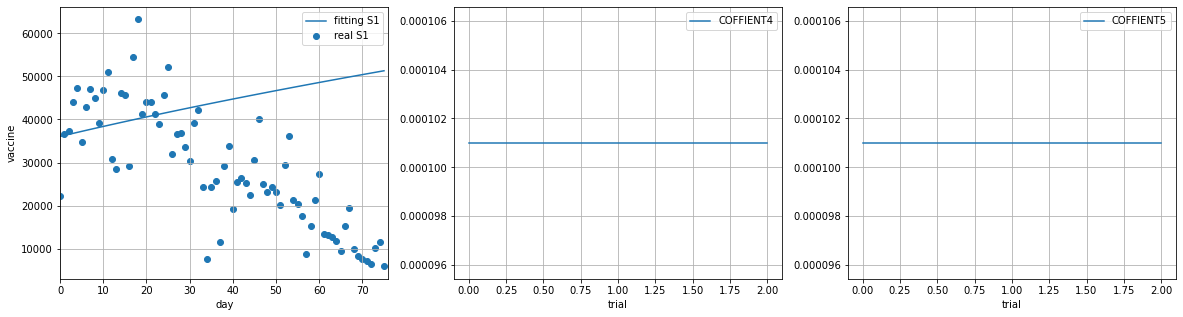

(COFFIENT4, COFFIENT5) =  0.00010100000150501728  ,  0.000101


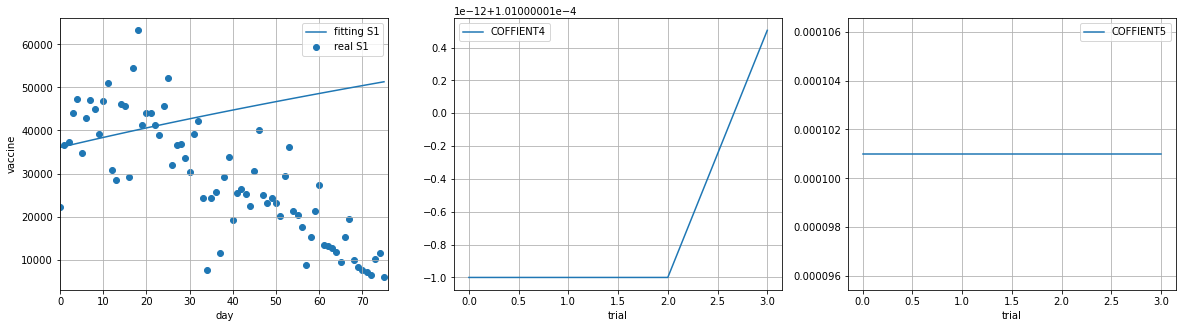

(COFFIENT4, COFFIENT5) =  0.000101  ,  0.00010100000150501728


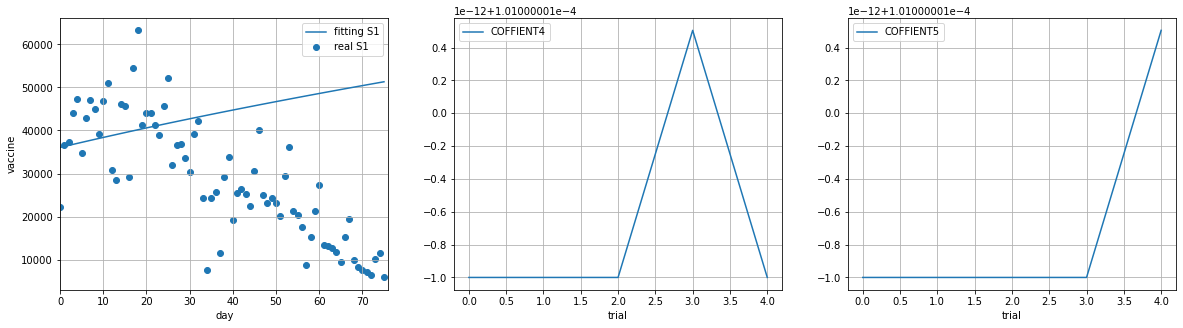

(COFFIENT4, COFFIENT5) =  -0.002174130894636938  ,  -3.9089272514031066


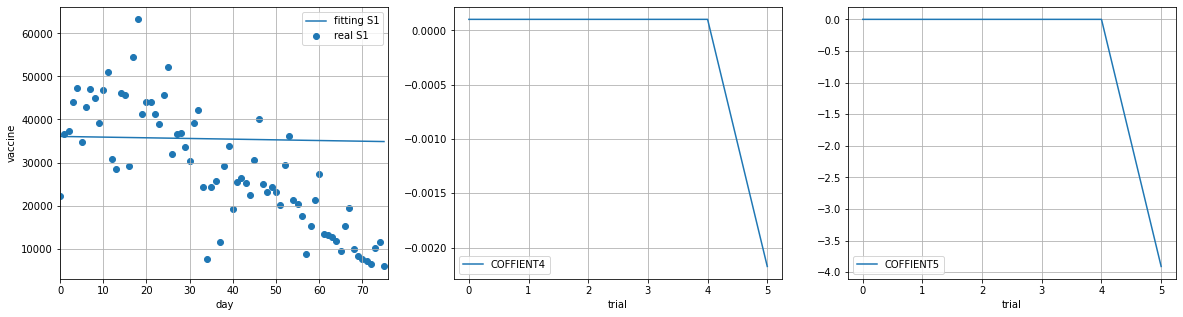

(COFFIENT4, COFFIENT5) =  -0.002174130862239863  ,  -3.9089272514031066


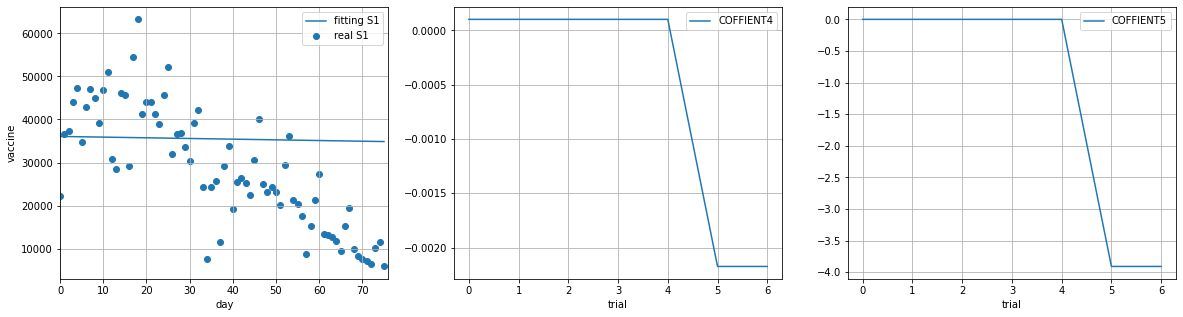

(COFFIENT4, COFFIENT5) =  -0.002174130894636938  ,  -3.9089271931555514


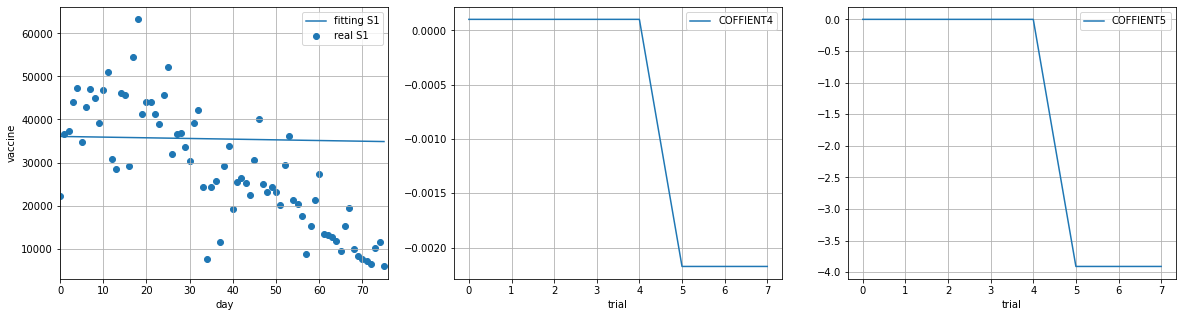

(COFFIENT4, COFFIENT5) =  0.004724546024282549  ,  -3.908927449583945


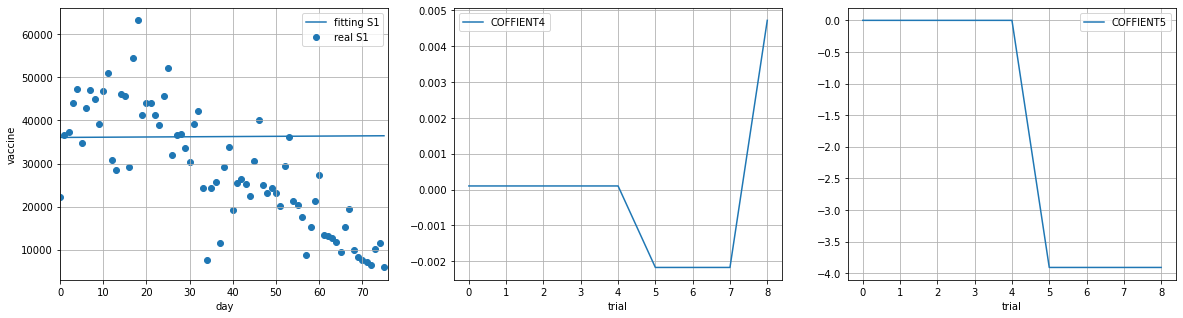

(COFFIENT4, COFFIENT5) =  0.00018731032088536688  ,  -3.9089273227559698


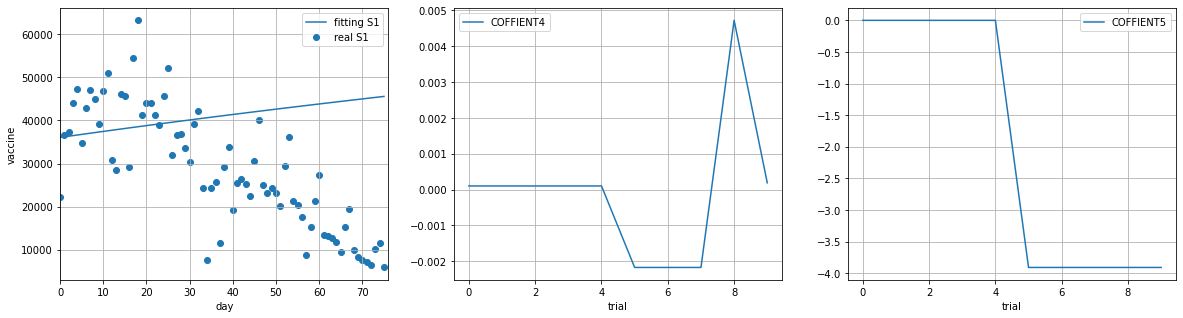

(COFFIENT4, COFFIENT5) =  -0.0019240710767914168  ,  -3.9089272591017172


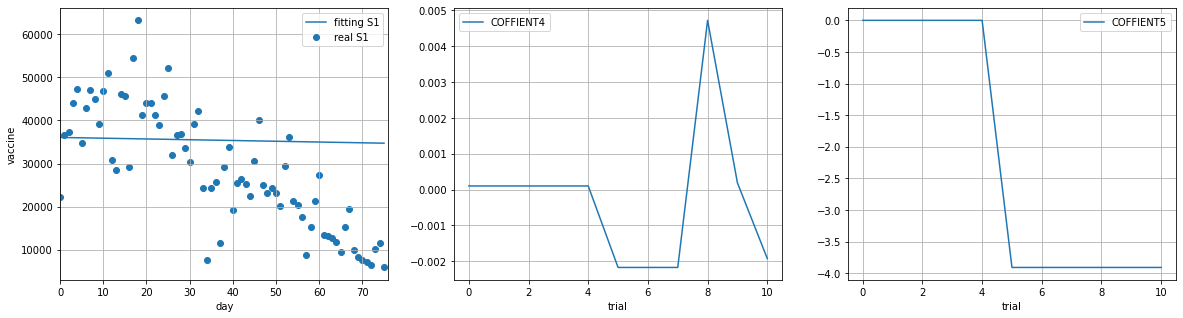

(COFFIENT4, COFFIENT5) =  -0.0019240710481205235  ,  -3.9089272591017172


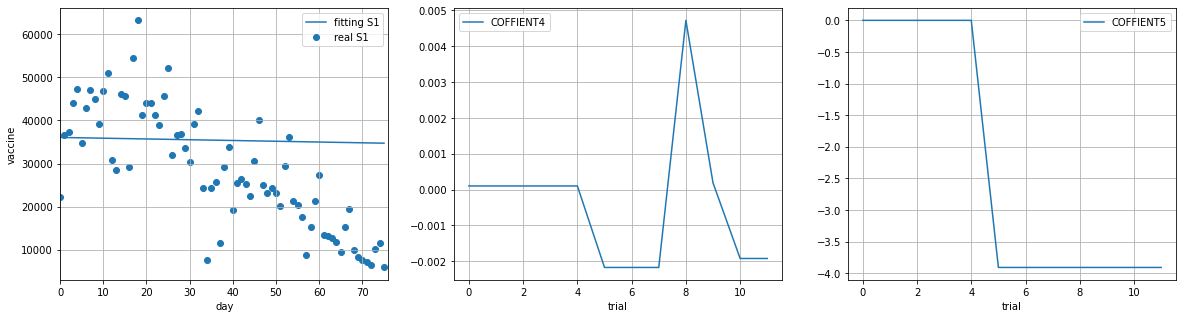

(COFFIENT4, COFFIENT5) =  -0.0019240710767914168  ,  -3.908927200854162


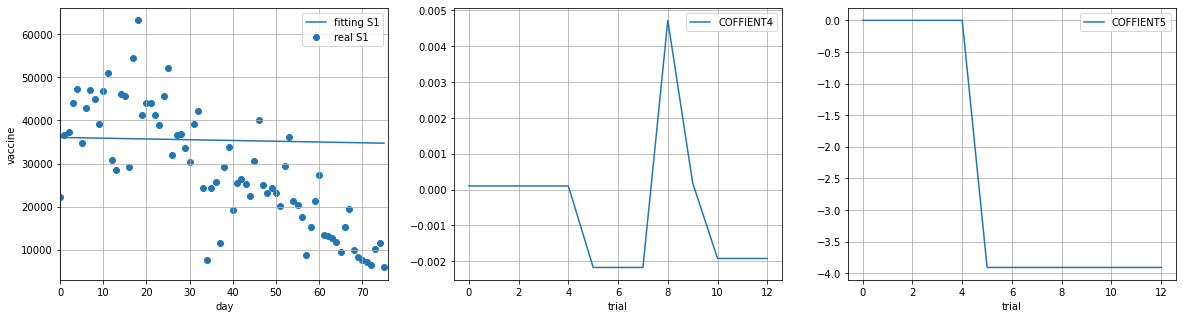

(COFFIENT4, COFFIENT5) =  -0.0014239514411003742  ,  -3.9089272601947225


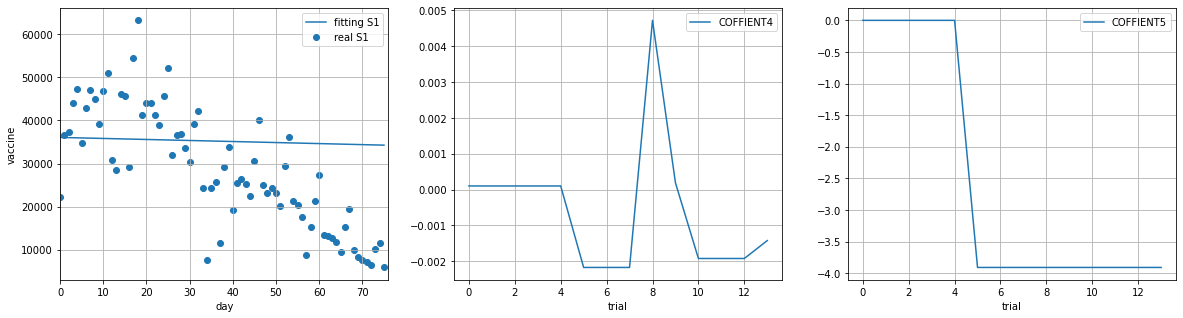

(COFFIENT4, COFFIENT5) =  -0.0014239514198818443  ,  -3.9089272601947225


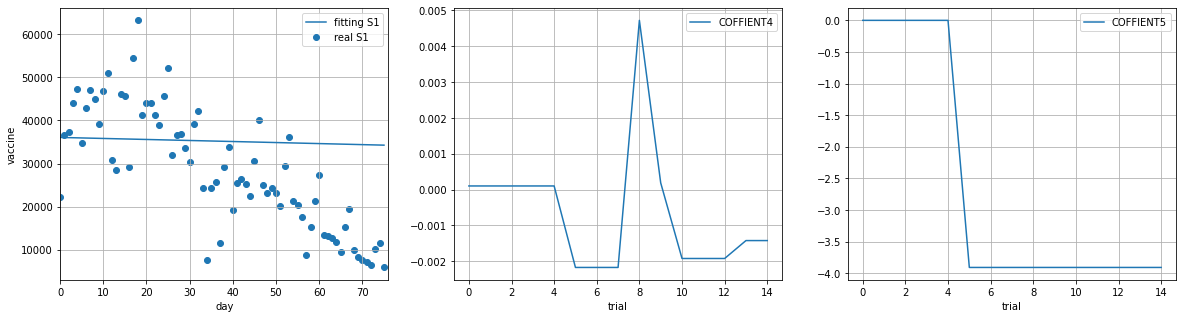

(COFFIENT4, COFFIENT5) =  -0.0014239514411003742  ,  -3.9089272019471673


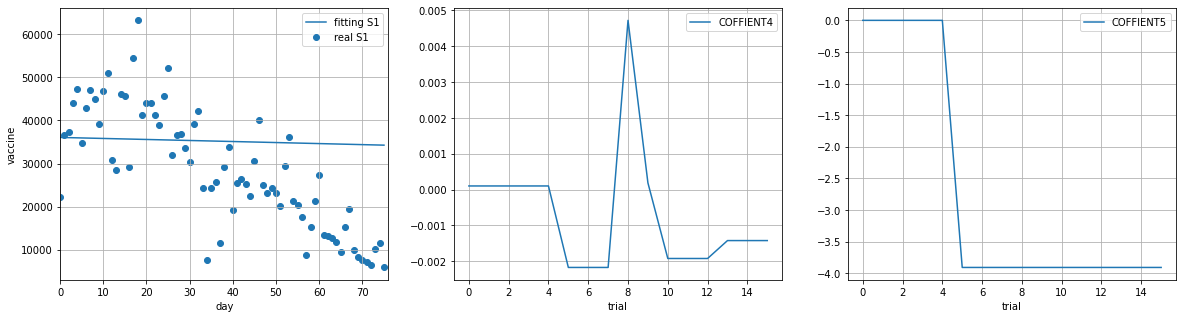

(COFFIENT4, COFFIENT5) =  -0.0004237121697183567  ,  -3.908927816198517


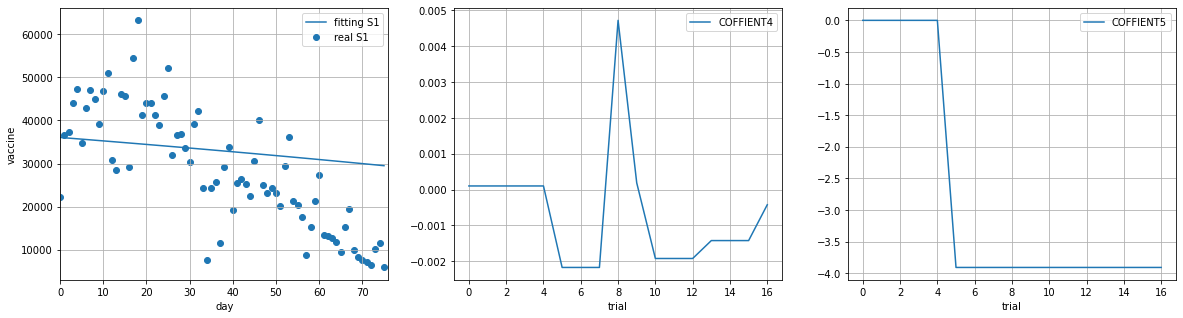

(COFFIENT4, COFFIENT5) =  -0.00042371216340455337  ,  -3.908927816198517


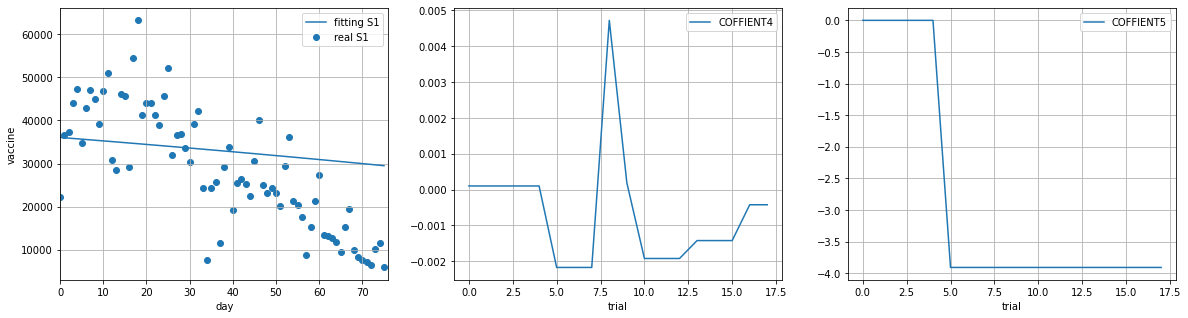

(COFFIENT4, COFFIENT5) =  -0.0004237121697183567  ,  -3.9089277579509534


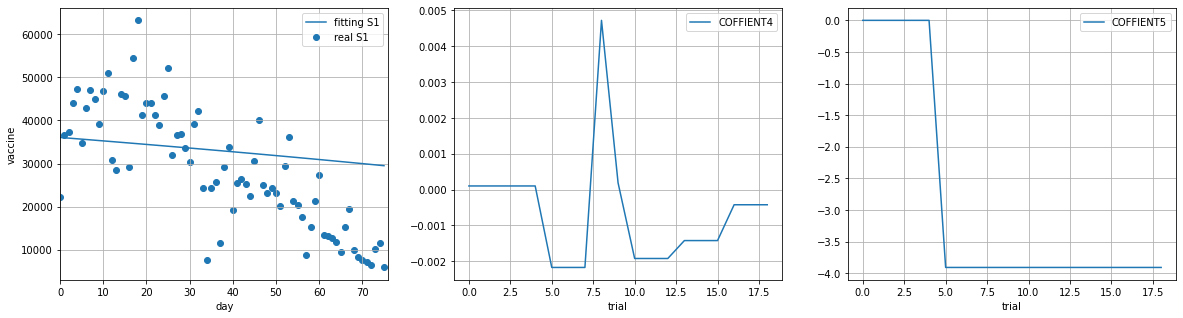

(COFFIENT4, COFFIENT5) =  0.00042806239245640873  ,  -6.925145295785321


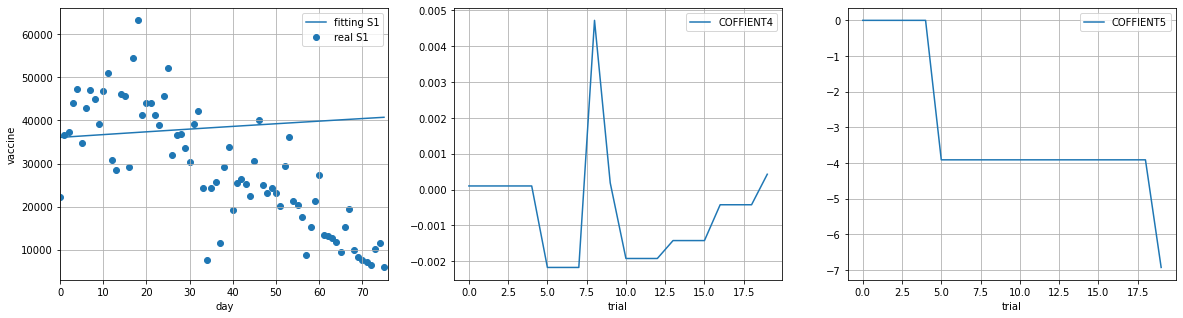

(COFFIENT4, COFFIENT5) =  7.168444729505291e-05  ,  -3.9089278169710955


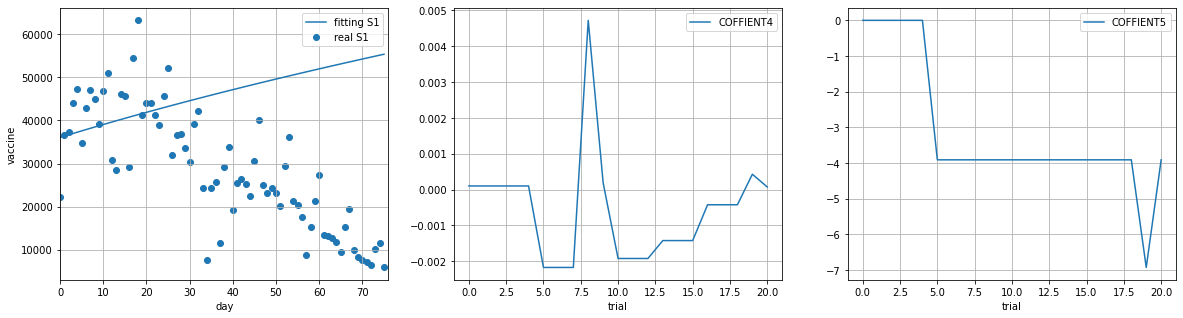

(COFFIENT4, COFFIENT5) =  -0.0003741725080170163  ,  -3.908927816263781


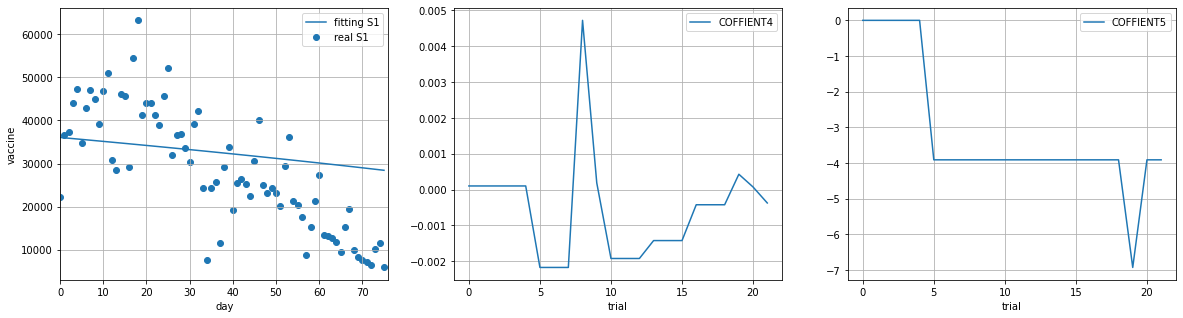

(COFFIENT4, COFFIENT5) =  -0.00037417250244141143  ,  -3.908927816263781


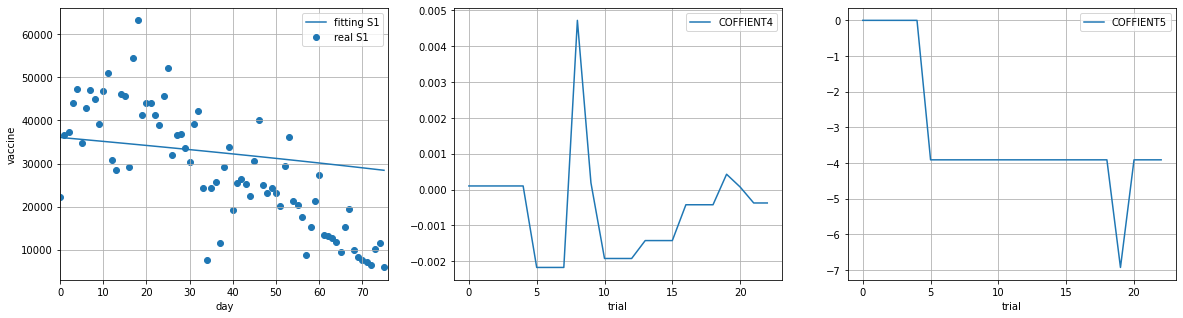

(COFFIENT4, COFFIENT5) =  -0.0003741725080170163  ,  -3.908927758016217


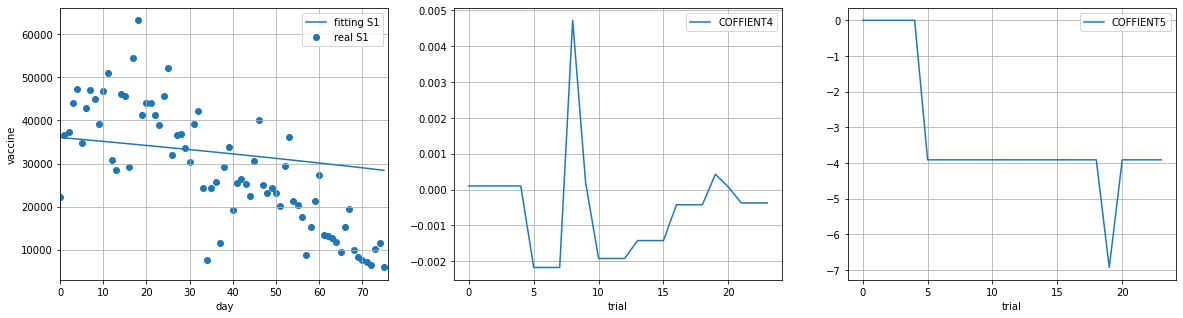

(COFFIENT4, COFFIENT5) =  -0.0002654944313028561  ,  -3.9089278171690096


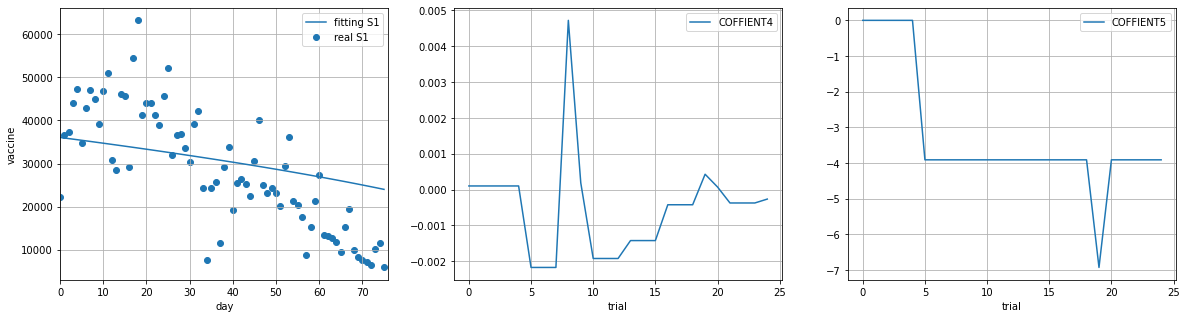

(COFFIENT4, COFFIENT5) =  -0.00026549442734668074  ,  -3.9089278171690096


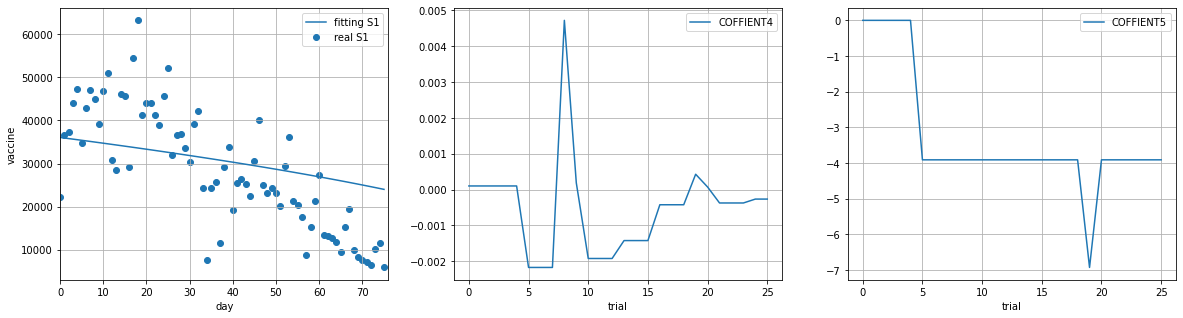

(COFFIENT4, COFFIENT5) =  -0.0002654944313028561  ,  -3.908927758921446


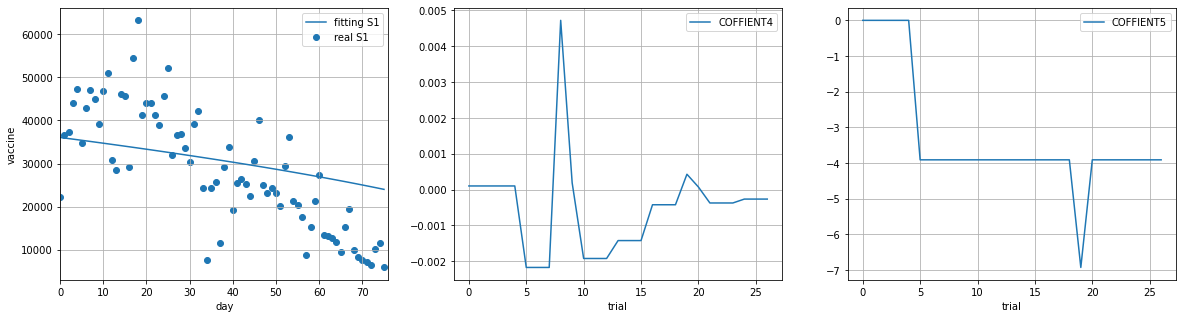

(COFFIENT4, COFFIENT5) =  -8.811201729494439e-05  ,  -3.6881485591414624


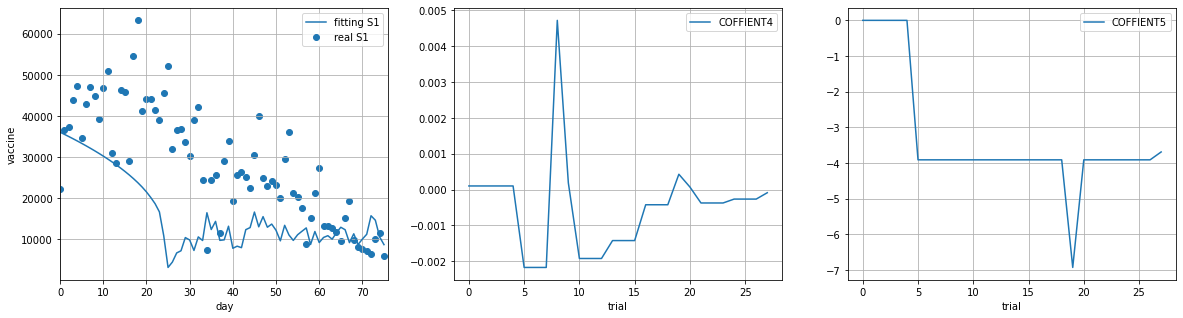

(COFFIENT4, COFFIENT5) =  -0.00023291932911754046  ,  -3.9089278173141957


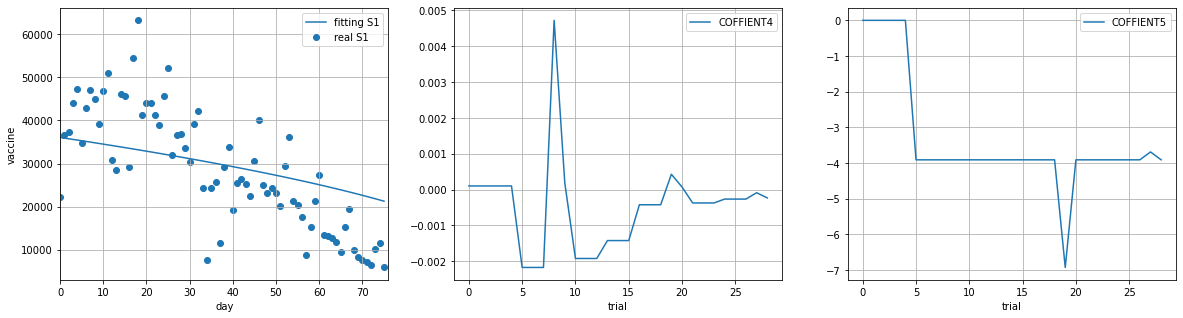

(COFFIENT4, COFFIENT5) =  -0.000232919325646772  ,  -3.9089278173141957


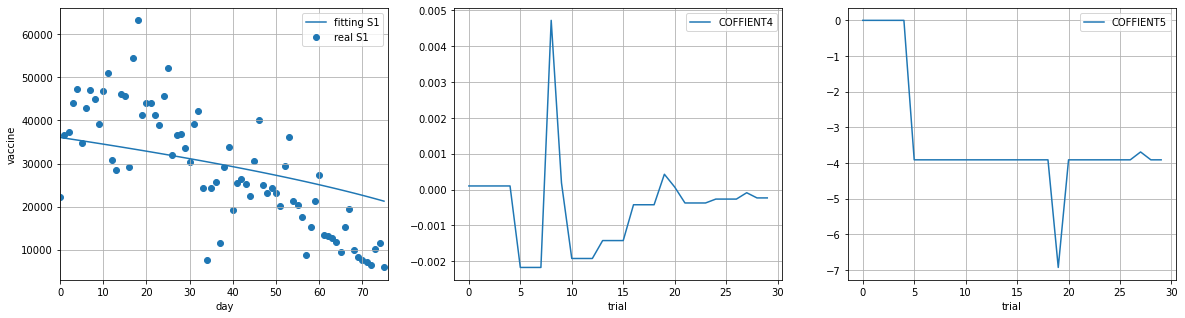

(COFFIENT4, COFFIENT5) =  -0.00023291932911754046  ,  -3.908927759066632


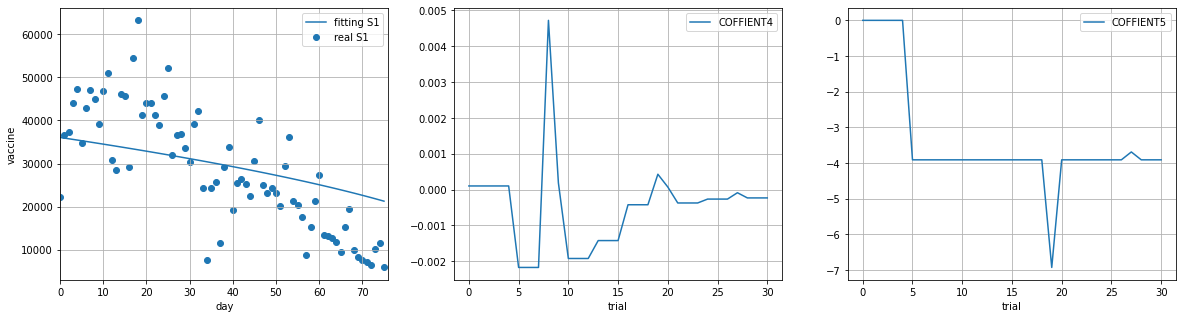

(COFFIENT4, COFFIENT5) =  -0.0001677691247469092  ,  -3.908927817499147


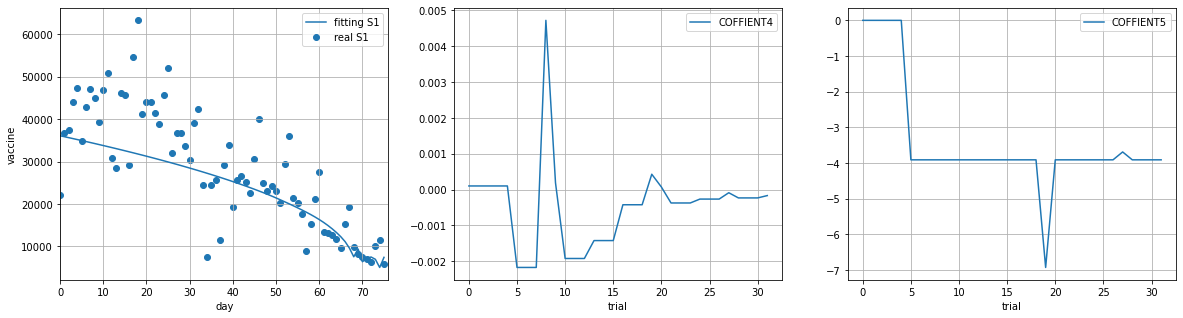

(COFFIENT4, COFFIENT5) =  -0.00016776912224695443  ,  -3.908927817499147


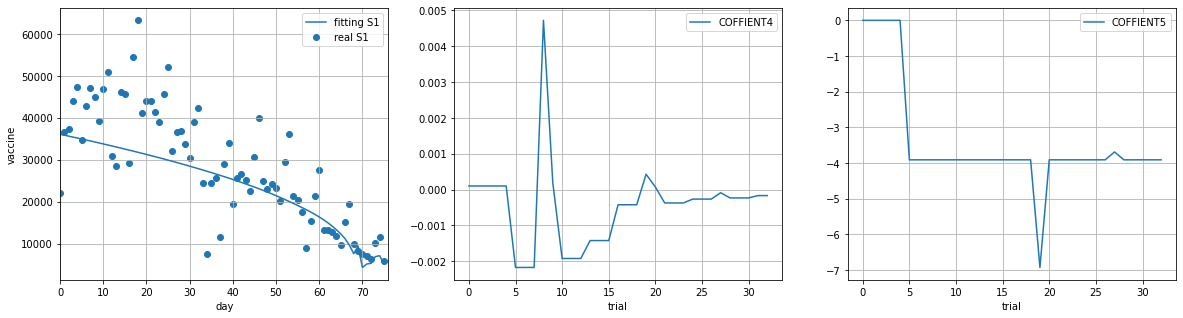

(COFFIENT4, COFFIENT5) =  -0.0001677691247469092  ,  -3.908927759251583


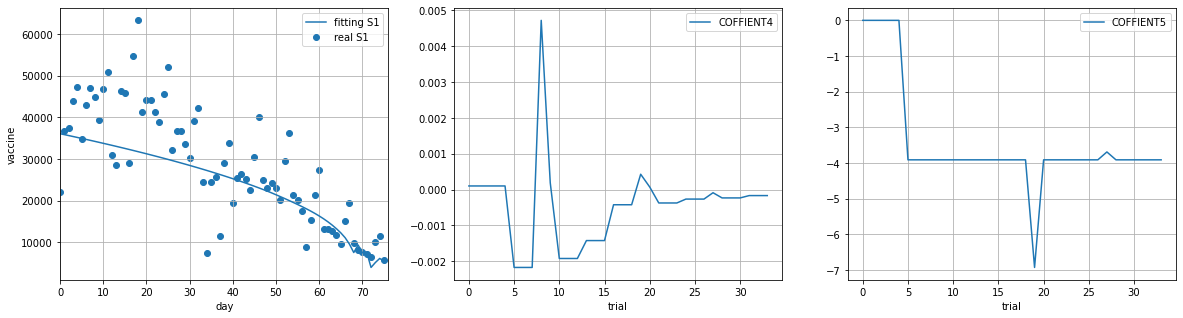

(COFFIENT4, COFFIENT5) =  -0.00016776912307657363  ,  -3.9089278120047073


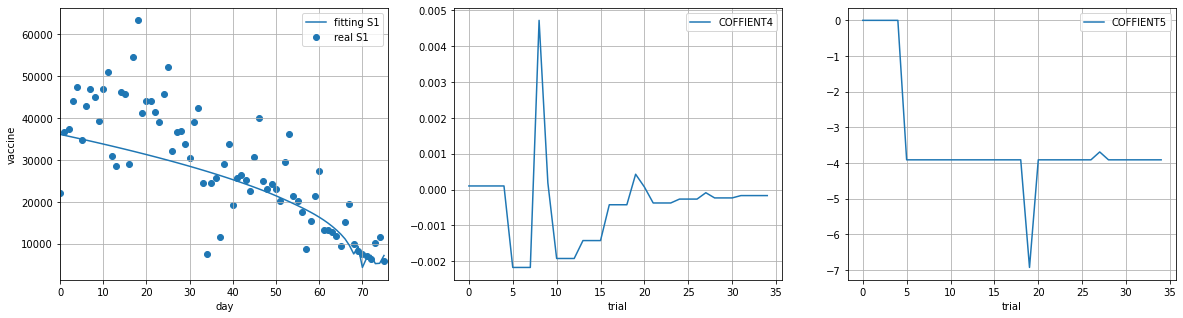

(COFFIENT4, COFFIENT5) =  -0.00016776912307657363  ,  -3.9089278120047073


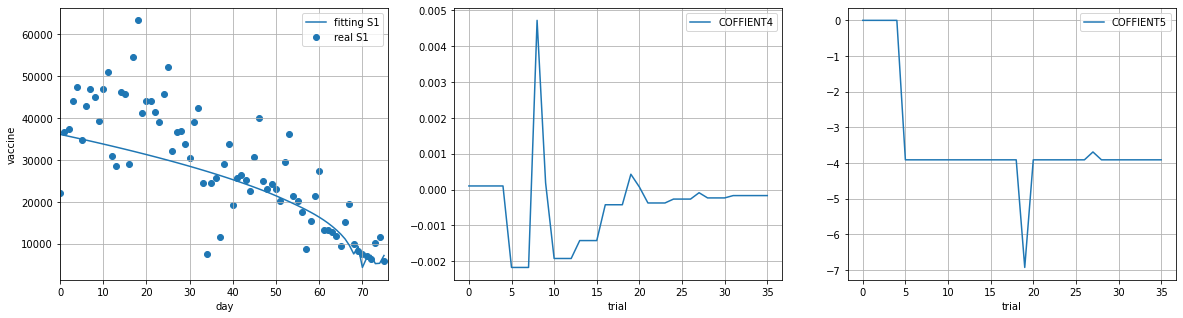

(COFFIENT4, COFFIENT5) =  -0.00016776912338636817  ,  -3.9089278097636617


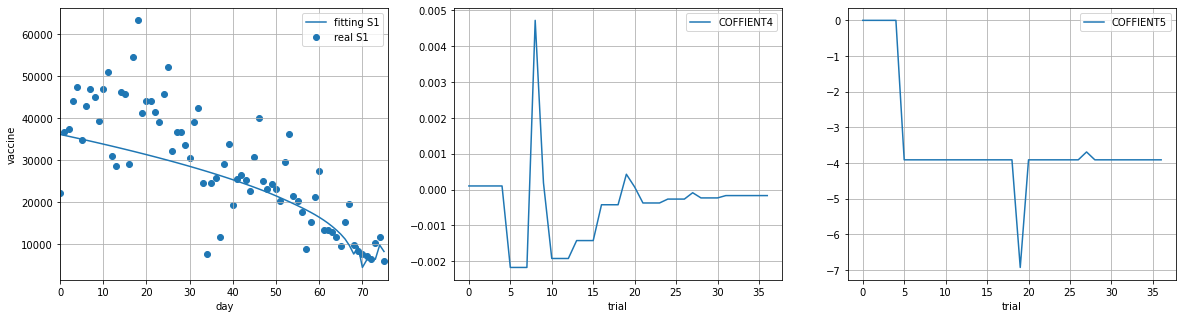

終了

(COFFIENT4_hat, COFFIENT5_hat) =  -0.00016776912338636817  ,  -3.9089278097636617
cov =  [[ 3.32647500e-23 -4.00908882e-19]
 [-4.00908882e-19  1.90075461e-14]]


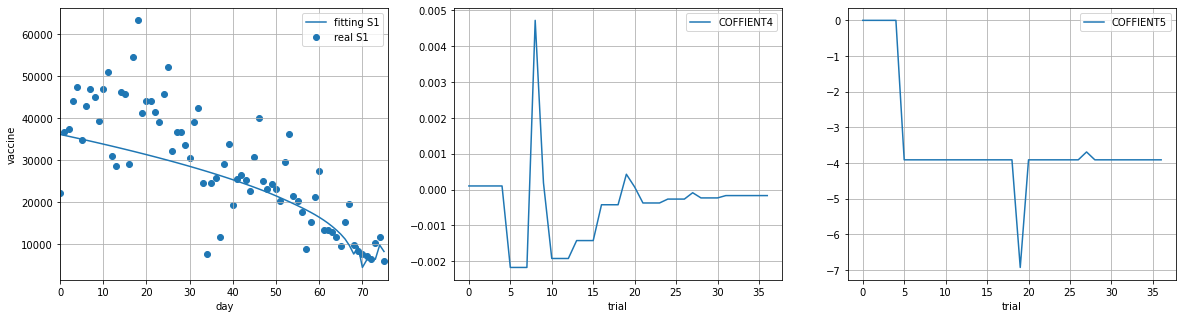

In [4]:
T = 76 # 終端条件
STEP = 1 

"""ワクチン1回目接種者のグラフ"""

t_observed = np.arange(0, T, STEP)

vaccine_date_rate_observed = np.array([
    22150,36686, 37369, 43958, 47348, 34761, 42906, 46990, 44926, 39258, 46815,
    50922, 30911, 28519, 46239, 45767, 29099, 54592, 63243, 41259, 44113,
    44044, 41361, 38948, 45607, 52108, 32071, 36610, 36758, 33658, 30352,
    39097, 42277, 24379,  7547, 24411, 25629, 11601, 29094, 33881, 19335,
    25559, 26479, 25234, 22507, 30595, 40039, 24923, 23086, 24315, 23165,
    20132, 29455, 36124, 21322, 20292, 17593,  8865, 15314, 21266, 27426,
    13309, 13201, 12769, 11749,  9565, 15194, 19400,  9841,  8289,  7587,
    7135,  6430, 10084, 11578, 5892
])


model = Fitting(
    animated=True,
    t_observed=t_observed,
    S1_observed=vaccine_date_rate_observed,
    TIME_INTERVAL=STEP
)

# パラメータの初期値
#p_init = [3.0e8, 3.0e8]  # 全然ダメ
#p_init = [0, 0]  # 収束するがダメ
p_init = [1.01e-4, 1.01e-4]  #収束しました

popt, pcov = model.find_param(p_init)
print("終了\n")
print("(COFFIENT4_hat, COFFIENT5_hat) = ", popt[0], " , ", popt[1])
print("cov = ", pcov)
model.draw(auto_close=True)

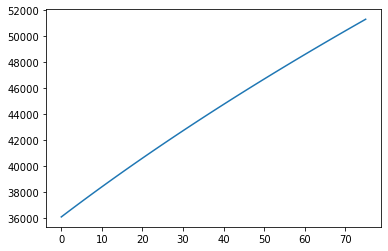

In [5]:
models = SEIRModel(TIME_INTERVAL =1)
t = np.arange(0, 76, 1)
models.COFFIENT4 = 1.01e-4
models.COFFIENT5 = 1.01e-4
models.run_sim(t)
plt.plot(models.sol.t, models.sol.y[4])
#plt.scatter(t_observed, vaccine_date_rate_observed)
plt.show()